In [ ]:
import pandas as pd
import numpy as np

# Visualización
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluar linealidad de las relaciones entre las variables
# y la distribución de las variables
# ------------------------------------------------------------------------------
import scipy.stats as stats
from scipy.stats import shapiro, kstest, poisson, chisquare, ttest_ind, levene, bartlett, sem

# Imputación de nulos usando métodos avanzados estadísticos
# -----------------------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

# Configuración
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames

# Gestión de los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

# fase 1. exploración y limpieza de datos

In [2]:
df_activity =pd.read_csv('../files/Customer Flight Activity.csv')
df_history = pd.read_csv('../files/Customer Loyalty History.csv')

_______________________________________________________

**1.1_comenzamos con Customer Flight Activity**

In [3]:
df_activity.head()

,Loyalty Number,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed
0,100018,2017,1,3,0,3,1521,152.0,0,0
1,100102,2017,1,10,4,14,2030,203.0,0,0
2,100140,2017,1,6,0,6,1200,120.0,0,0
3,100214,2017,1,0,0,0,0,0.0,0,0
4,100272,2017,1,0,0,0,0,0.0,0,0


In [4]:
#conozcamos las dimensiones de la tabla
print(f'nº filas:{df_activity.shape[0]}')
print(f'nº columnas:{df_activity.shape[1]}')

nº filas:405624
nº columnas:10


In [5]:
#info datos para conocer su tipo, el número de no nulos y la cantidad de datos que estamos manejando.
#los resultados nos invitan a descartar la comprobación de nulos.
df_activity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405624 entries, 0 to 405623
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Loyalty Number               405624 non-null  int64  
 1   Year                         405624 non-null  int64  
 2   Month                        405624 non-null  int64  
 3   Flights Booked               405624 non-null  int64  
 4   Flights with Companions      405624 non-null  int64  
 5   Total Flights                405624 non-null  int64  
 6   Distance                     405624 non-null  int64  
 7   Points Accumulated           405624 non-null  float64
 8   Points Redeemed              405624 non-null  int64  
 9   Dollar Cost Points Redeemed  405624 non-null  int64  
dtypes: float64(1), int64(9)
memory usage: 30.9 MB


In [6]:
#recuperamos los datos estadísticos de las columnas numéricas de 'df_flight' -en este caso, todas-
df_activity.describe().T

,count,mean,std,min,25%,50%,75%,max
Loyalty Number,405624.0,550037.873084,258935.286969,100018.0,326961.00,550834.0,772194.00,999986.0
Year,405624.0,2017.500000,0.500001,2017.0,2017.00,2017.5,2018.00,2018.0
Month,405624.0,6.500000,3.452057,1.0,3.75,6.5,9.25,12.0
Flights Booked,405624.0,4.115052,5.225518,0.0,0.00,1.0,8.00,21.0
Flights with Companions,405624.0,1.031805,2.076869,0.0,0.00,0.0,1.00,11.0
Total Flights,405624.0,5.146858,6.521227,0.0,0.00,1.0,10.00,32.0
Distance,405624.0,1208.880059,1433.155320,0.0,0.00,488.0,2336.00,6293.0
Points Accumulated,405624.0,123.692721,146.599831,0.0,0.00,50.0,239.00,676.5
Points Redeemed,405624.0,30.696872,125.486049,0.0,0.00,0.0,0.00,876.0
Dollar Cost Points Redeemed,405624.0,2.484503,10.150038,0.0,0.00,0.0,0.00,71.0


In [7]:
#observamos los valores únicos de cada columna iterando por cada una de ellas con un bucle for:
for col in df_activity:
    print(f'Estos son los valores únicos de la columna {col.upper()}')
    print(df_activity[col].unique())
    print('\n ------------------------------ \n')

Estos son los valores únicos de la columna LOYALTY NUMBER
[100018 100102 100140 ... 999731 999788 999891]

 ------------------------------ 

Estos son los valores únicos de la columna YEAR
[2017 2018]

 ------------------------------ 

Estos son los valores únicos de la columna MONTH
[ 1  9  2  3 11  4  5  7  6  8 10 12]

 ------------------------------ 

Estos son los valores únicos de la columna FLIGHTS BOOKED
[ 3 10  6  0  8 11  9  4  7  5  2  1 12 13 14 16 15 17 18 19 20 21]

 ------------------------------ 

Estos son los valores únicos de la columna FLIGHTS WITH COMPANIONS
[ 0  4  7  1  6  3  5  2 10  8  9 11]

 ------------------------------ 

Estos son los valores únicos de la columna TOTAL FLIGHTS
[ 3 14  6  0 15 11 12 10  8  9  7  5 16  2  1 17 13 22  4 19 18 21 26 20
 23 25 27 24 28 30 29 31 32]

 ------------------------------ 

Estos son los valores únicos de la columna DISTANCE
[1521 2030 1200 ... 1217  617 4135]

 ------------------------------ 

Estos son los valores ún

In [8]:
#comprobación de filas duplicadas
df_activity.duplicated().sum()

1864

In [9]:
#al tener un número de filas duplicadas tan elevado, comprobamos 
#cuál es el número de datos duplicados en la columna identitaria 
df_activity['Loyalty Number'].duplicated().sum()

388887

In [10]:
#comprobamos cuáles son los casos en los que los valores en 'loyalty number' se repite
df_activity[df_activity['Loyalty Number'].duplicated().sort_values()]


,Loyalty Number,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed
37,100504,2017,2,0,0,0,0,0.0,0,0
39,100504,2017,3,0,0,0,0,0.0,0,0
42,101902,2017,1,0,0,0,0,0.0,0,0
88,100504,2017,4,0,0,0,0,0.0,0,0
101,100504,2017,5,0,0,0,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...
405619,999902,2018,12,0,0,0,0,0.0,0,0
405620,999911,2018,12,0,0,0,0,0.0,0,0
405621,999940,2018,12,3,0,3,1233,123.0,0,0
405622,999982,2018,12,0,0,0,0,0.0,0,0


_______________________________________________________

**1.2_comenzamos con Customer Loyalty History**

In [11]:
df_history.head()

,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,3839.14,Standard,2016,2,NaN,NaN
1,549612,Canada,Alberta,Edmonton,T3G 6Y6,Male,College,NaN,Divorced,Star,3839.61,Standard,2016,3,NaN,NaN
2,429460,Canada,British Columbia,Vancouver,V6E 3D9,Male,College,NaN,Single,Star,3839.75,Standard,2014,7,2018.0,1.0
3,608370,Canada,Ontario,Toronto,P1W 1K4,Male,College,NaN,Single,Star,3839.75,Standard,2013,2,NaN,NaN
4,530508,Canada,Quebec,Hull,J8Y 3Z5,Male,Bachelor,103495.0,Married,Star,3842.79,Standard,2014,10,NaN,NaN


In [12]:
#conozcamos las dimensiones de la tabla
print(f'nº filas:{df_history.shape[0]}')
print(f'nº columnas:{df_history.shape[1]}')

nº filas:16737
nº columnas:16


In [ ]:
#comprobación de datos duplicados
df_history.duplicated().sum()

0

In [ ]:
#información sobre los datos: comprobamos en este caso la gran cantidad de nulos, por lo que procedemos a inspeccionarlos más detenidamente
df_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Loyalty Number      16737 non-null  int64  
 1   Country             16737 non-null  object 
 2   Province            16737 non-null  object 
 3   City                16737 non-null  object 
 4   Postal Code         16737 non-null  object 
 5   Gender              16737 non-null  object 
 6   Education           16737 non-null  object 
 7   Salary              12499 non-null  float64
 8   Marital Status      16737 non-null  object 
 9   Loyalty Card        16737 non-null  object 
 10  CLV                 16737 non-null  float64
 11  Enrollment Type     16737 non-null  object 
 12  Enrollment Year     16737 non-null  int64  
 13  Enrollment Month    16737 non-null  int64  
 14  Cancellation Year   2067 non-null   float64
 15  Cancellation Month  2067 non-null   float64
dtypes: f

In [67]:
#observamos los valores únicos de cada columna iterando por cada una de ellas con un bucle for:
for col in df_history:
    print(f'Estos son los valores únicos de la columna {col.upper()}')
    print(df_history[col].unique())
    print('\n ------------------------------ \n')

Estos son los valores únicos de la columna LOYALTY NUMBER
[480934 549612 429460 ... 776187 906428 652627]

 ------------------------------ 

Estos son los valores únicos de la columna COUNTRY
['Canada']

 ------------------------------ 

Estos son los valores únicos de la columna PROVINCE
['Ontario' 'Alberta' 'British Columbia' 'Quebec' 'Yukon' 'New Brunswick'
 'Manitoba' 'Nova Scotia' 'Saskatchewan' 'Newfoundland'
 'Prince Edward Island']

 ------------------------------ 

Estos son los valores únicos de la columna CITY
['Toronto' 'Edmonton' 'Vancouver' 'Hull' 'Whitehorse' 'Trenton' 'Montreal'
 'Dawson Creek' 'Quebec City' 'Fredericton' 'Ottawa' 'Tremblant' 'Calgary'
 'Thunder Bay' 'Whistler' 'Peace River' 'Winnipeg' 'Sudbury'
 'West Vancouver' 'Halifax' 'London' 'Regina' 'Kelowna' "St. John's"
 'Victoria' 'Kingston' 'Banff' 'Moncton' 'Charlottetown']

 ------------------------------ 

Estos son los valores únicos de la columna POSTAL CODE
['M2Z 4K1' 'T3G 6Y6' 'V6E 3D9' 'P1W 1K4' 'J8Y

In [ ]:
df_history.isnull().sum()
#el primer vistazo nos destaca tres columnas con varios miles de datos nulos.
#entendemos por la documentación que las columnas de 'Cancellation Year' y 'Cancellation Month' 
#solo estarán rellenas cuando el cliente haya cancelado su suscripción

Loyalty Number            0
Country                   0
Province                  0
City                      0
Postal Code               0
Gender                    0
Education                 0
Salary                 4238
Marital Status            0
Loyalty Card              0
CLV                       0
Enrollment Type           0
Enrollment Year           0
Enrollment Month          0
Cancellation Year     14670
Cancellation Month    14670
dtype: int64

In [42]:
#sacamos los datos estadísticos de todas las columnas numéricas 
df_history.describe().T

,count,mean,std,min,25%,50%,75%,max
Loyalty Number,16737.0,549735.880445,258912.132453,100018.00,326603.00,550434.00,772019.00,999986.00
Salary,12499.0,79245.609409,35008.297285,-58486.00,59246.50,73455.00,88517.50,407228.00
CLV,16737.0,7988.896536,6860.982280,1898.01,3980.84,5780.18,8940.58,83325.38
Enrollment Year,16737.0,2015.253211,1.979111,2012.00,2014.00,2015.00,2017.00,2018.00
Enrollment Month,16737.0,6.669116,3.398958,1.00,4.00,7.00,10.00,12.00
Cancellation Year,2067.0,2016.503145,1.380743,2013.00,2016.00,2017.00,2018.00,2018.00
Cancellation Month,2067.0,6.962748,3.455297,1.00,4.00,7.00,10.00,12.00


In [40]:
#prestamos más atención a la columna 'Salary'
df_history['Salary'].unique()

array([ 83236.,     nan, 103495., ...,  76178.,  91970., -57297.])

In [ ]:
#según la documentación, 'Salary' es un dato que completa la compañía con una estimación del salario de sus suscritores
#procesos que realizaremos en esta columna: corrección de negativos, completaremos los nulos con la media.
df_history['Salary'].describe().T.reset_index().round()

,index,Salary
0,count,12499.0
1,mean,79246.0
2,std,35008.0
3,min,-58486.0
4,25%,59246.0
5,50%,73455.0
6,75%,88518.0
7,max,407228.0


In [ ]:
#y ahora comprobamos las características del conjuto de datos categóricos
df_history.describe(include='object').T

,count,unique,top,freq
Country,16737,1,Canada,16737
Province,16737,11,Ontario,5404
City,16737,29,Toronto,3351
Postal Code,16737,55,V6E 3D9,911
Gender,16737,2,Female,8410
Education,16737,5,Bachelor,10475
Marital Status,16737,3,Married,9735
Loyalty Card,16737,3,Star,7637
Enrollment Type,16737,2,Standard,15766


_______________________________________________________

**1.4_tareas de limpieza**

In [ ]:
#corregimos los valores negativos de la columna 'Salary'
df_history['Salary'] = df_history['Salary'].apply(lambda x: -x if x < 0 else x)
df_history['Salary'].describe().T.round(2)

count     12499.00
mean      79359.34
std       34749.69
min        9081.00
25%       59246.50
50%       73455.00
75%       88517.50
max      407228.00
Name: Salary, dtype: float64

<Axes: xlabel='Salary'>

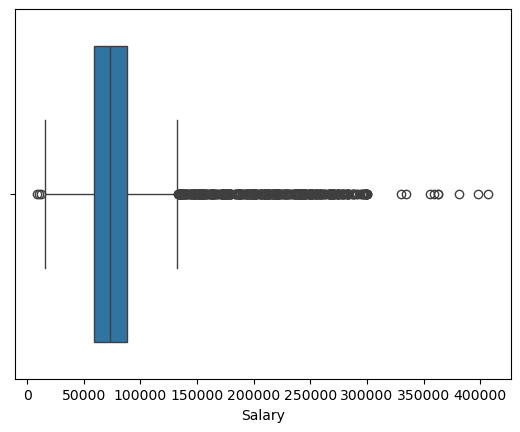

In [ ]:
#antes de imputar los valores nulos, comprobamos por medio de una visualización si nuestra columna tiene valores atípico
sns.boxplot(x = 'Salary', data = df_history)
#la cantidad de valores atípicos es muy elevada, optamos por aplicar 

In [ ]:
#empezamos la prueba con KNNImputer, para ello crearemos primero una copia de nuestro df
df_history_c = df_history.copy()
#
imp_knn = KNNImputer(n_neighbors=20)
imp_knn_d = imp_knn.fit_transform(df_history_c[['Salary']])
df_history_c['Salary'] = imp_knn_d
df_history_c['Salary'].describe().T.reset_index().round()

,index,Salary
0,count,16737.0
1,mean,79359.0
2,std,30029.0
3,min,9081.0
4,25%,63899.0
5,50%,79359.0
6,75%,82940.0
7,max,407228.0


In [70]:
it_imp = IterativeImputer(max_iter = 50, random_state = 100)
it_imp_d = it_imp.fit_transform(df_history_c[['Salary']])
df_history_c['Salary'] = it_imp_d
df_history_c['Salary'].describe().T.reset_index().round(2)

,index,Salary
0,count,16737.00
1,mean,79359.34
2,std,30029.31
3,min,9081.00
4,25%,63899.00
5,50%,79359.34
6,75%,82940.00
7,max,407228.00


In [72]:
df_history_c.head()

,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.000000,Married,Star,3839.14,Standard,2016,2,NaN,NaN
1,549612,Canada,Alberta,Edmonton,T3G 6Y6,Male,College,79359.340907,Divorced,Star,3839.61,Standard,2016,3,NaN,NaN
2,429460,Canada,British Columbia,Vancouver,V6E 3D9,Male,College,79359.340907,Single,Star,3839.75,Standard,2014,7,2018.0,1.0
3,608370,Canada,Ontario,Toronto,P1W 1K4,Male,College,79359.340907,Single,Star,3839.75,Standard,2013,2,NaN,NaN
4,530508,Canada,Quebec,Hull,J8Y 3Z5,Male,Bachelor,103495.000000,Married,Star,3842.79,Standard,2014,10,NaN,NaN


In [73]:
df_history_c.isnull().sum()

Loyalty Number            0
Country                   0
Province                  0
City                      0
Postal Code               0
Gender                    0
Education                 0
Salary                    0
Marital Status            0
Loyalty Card              0
CLV                       0
Enrollment Type           0
Enrollment Year           0
Enrollment Month          0
Cancellation Year     14670
Cancellation Month    14670
dtype: int64

_______________________________________________________

**1.5_tareas de filtrado**

In [14]:
#al encontrar que en el segundo csv los datos no están duplicados y que los datos duplicados del primero son registrales e 'irrelevantes' para esta parte del estudio, procedemos a realizar una agrupación de datos basadas en el número identitario de clientes y sumando los vuelos que ha reservado y la acumulación de sus puntos
df_gr_activity = df_activity.groupby('Loyalty Number').agg({'Flights Booked':'sum', 'Points Accumulated':'sum'}).reset_index()
df_gr_activity['Loyalty Number'].duplicated().sum()

0

In [ ]:
#comprobamos que el número de filas ahora coindice con 'df_history' y que la fusión es posible 
df_gr_activity.shape

(16737, 3)

_______________________________________________________

**1.6_fusión de tablas**

In [75]:
df_gr_activity.columns

Index(['Loyalty Number', 'Flights Booked', 'Points Accumulated'], dtype='object')

In [79]:
#el método de unión sera 'left merge' a través de la columna 'Loyalty Number' y utilizando la versión de los df's corregida/filtrada
df_merg = df_gr_activity.merge(right=df_history_c, how='left',left_on='Loyalty Number', right_on='Loyalty Number')
df_merg.head()

,Loyalty Number,Flights Booked,Points Accumulated,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month
0,100018,157,5376.00,Canada,Alberta,Edmonton,T9G 1W3,Female,Bachelor,92552.000000,Married,Aurora,7919.20,Standard,2016,8,NaN,NaN
1,100102,173,4115.25,Canada,Ontario,Toronto,M1R 4K3,Male,College,79359.340907,Single,Nova,2887.74,Standard,2013,3,NaN,NaN
2,100140,152,4184.25,Canada,British Columbia,Dawson Creek,U5I 4F1,Female,College,79359.340907,Divorced,Nova,2838.07,Standard,2016,7,NaN,NaN
3,100214,79,3426.00,Canada,British Columbia,Vancouver,V5R 1W3,Male,Bachelor,63253.000000,Married,Star,4170.57,Standard,2015,8,NaN,NaN
4,100272,127,4108.04,Canada,Ontario,Toronto,P1L 8X8,Female,Bachelor,91163.000000,Divorced,Star,6622.05,Standard,2014,1,NaN,NaN


In [80]:
df_merg.duplicated().sum()

0

In [82]:
df_merg.isnull().sum()

Loyalty Number            0
Flights Booked            0
Points Accumulated        0
Country                   0
Province                  0
City                      0
Postal Code               0
Gender                    0
Education                 0
Salary                    0
Marital Status            0
Loyalty Card              0
CLV                       0
Enrollment Type           0
Enrollment Year           0
Enrollment Month          0
Cancellation Year     14670
Cancellation Month    14670
dtype: int64

In [83]:
df_merg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Loyalty Number      16737 non-null  int64  
 1   Flights Booked      16737 non-null  int64  
 2   Points Accumulated  16737 non-null  float64
 3   Country             16737 non-null  object 
 4   Province            16737 non-null  object 
 5   City                16737 non-null  object 
 6   Postal Code         16737 non-null  object 
 7   Gender              16737 non-null  object 
 8   Education           16737 non-null  object 
 9   Salary              16737 non-null  float64
 10  Marital Status      16737 non-null  object 
 11  Loyalty Card        16737 non-null  object 
 12  CLV                 16737 non-null  float64
 13  Enrollment Type     16737 non-null  object 
 14  Enrollment Year     16737 non-null  int64  
 15  Enrollment Month    16737 non-null  int64  
 16  Canc

In [ ]:
#posibles cambios:
#Cancellation Year + Month -> int